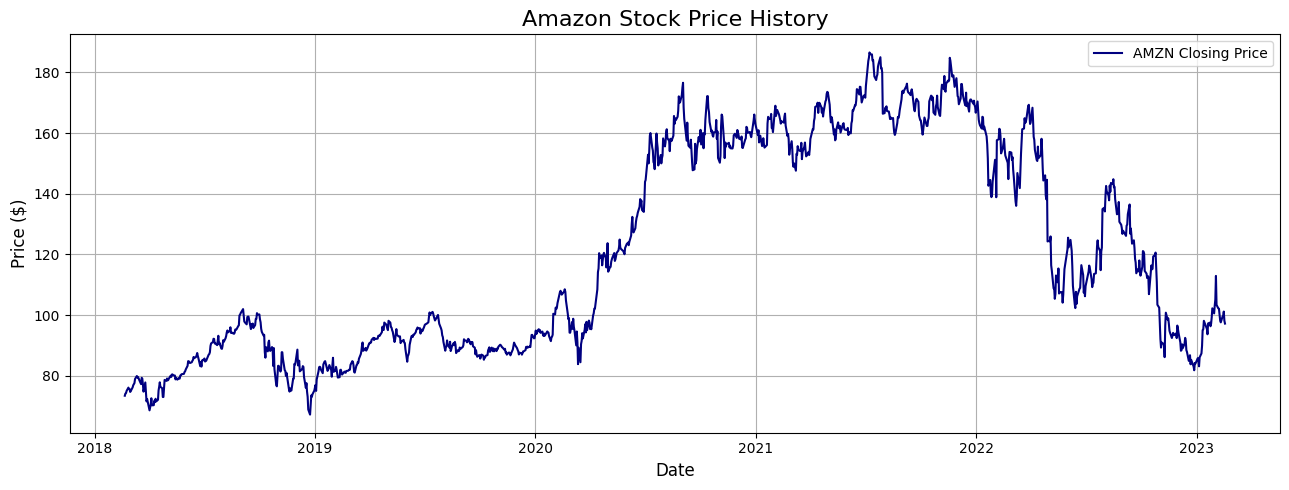

ADF p-value: 0.45297105465166737
KPSS p-value: 0.01
ADF (diff): 0.0
KPSS (diff): 0.1


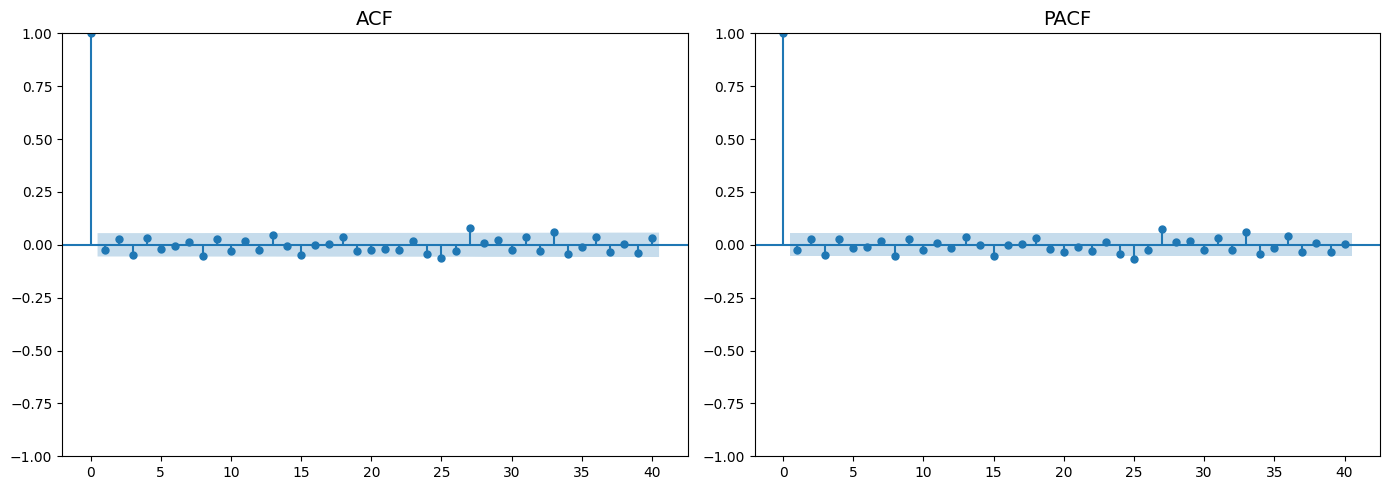

Optimal ARIMA order: (2, 1, 2)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# --- Load Data ---
data = pd.read_csv("AMZN.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
stock = data[['Close']].copy()

# --- Visualize Time Series ---
plt.figure(figsize=(13, 5))
plt.plot(stock, color='navy', label='AMZN Closing Price')
plt.title("Amazon Stock Price History", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Stationarity Check ---
adf_p = adfuller(stock['Close'])[1]
kpss_p = kpss(stock['Close'], regression='c', nlags="auto")[1]
print(f"ADF p-value: {adf_p}")
print(f"KPSS p-value: {kpss_p}")

# --- Differencing to Stabilize Mean ---
diff_stock = stock.diff().dropna()
adf_p_diff = adfuller(diff_stock['Close'])[1]
kpss_p_diff = kpss(diff_stock['Close'], regression='c', nlags="auto")[1]
print(f"ADF (diff): {adf_p_diff}")
print(f"KPSS (diff): {kpss_p_diff}")

# --- ACF and PACF Analysis ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(diff_stock, lags=40, ax=ax[0])
ax[0].set_title("ACF", fontsize=14)
plot_pacf(diff_stock, lags=40, ax=ax[1])
ax[1].set_title("PACF", fontsize=14)
plt.tight_layout()
plt.show()

# --- ARIMA Model Selection ---
best_aic = np.inf
best_order = None
final_arima = None

for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(stock['Close'], order=(p, 1, q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, 1, q)
                final_arima = model
        except:
            continue

print("Optimal ARIMA order:", best_order)




ARIMA Evaluation:
MAE : 2.9318
RMSE: 4.2158
MAPE: 2.85 %


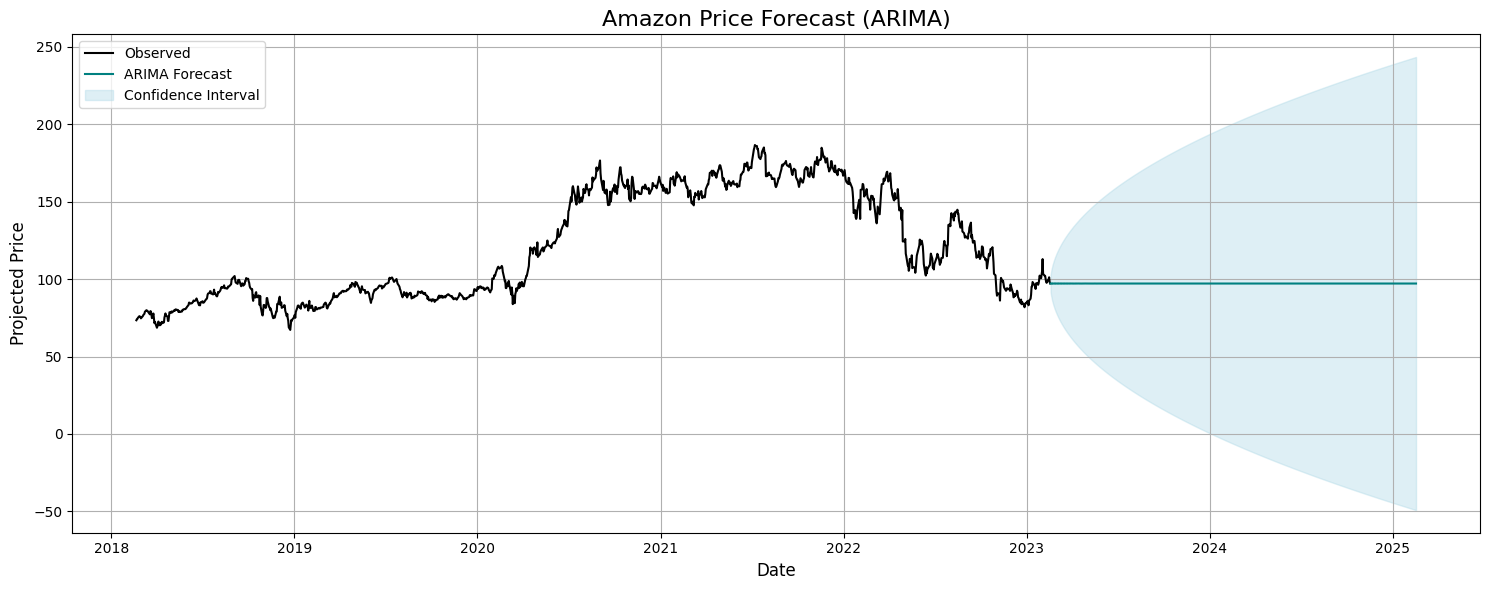

In [ ]:

future_arima = final_arima.get_forecast(steps=730)
forecast_values = future_arima.predicted_mean
conf_bounds = future_arima.conf_int()
future_dates = pd.date_range(start=stock.index[-1] + pd.Timedelta(days=1), periods=730)

# --- Short-Term Validation (Last 24 Days) ---
n_test = 24
train_arima = stock[:-n_test]
test_arima = stock[-n_test:]

model_eval = ARIMA(train_arima['Close'], order=best_order).fit()
test_forecast = model_eval.get_forecast(steps=n_test).predicted_mean

true_vals = test_arima['Close'].values
pred_vals = test_forecast.values

print("\nARIMA Evaluation:")
print("MAE :", round(mean_absolute_error(true_vals, pred_vals), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(true_vals, pred_vals)), 4))
print("MAPE:", round(mean_absolute_percentage_error(true_vals, pred_vals) * 100, 2), "%")

# --- Plot ARIMA Forecast ---
plt.figure(figsize=(15, 6))
plt.plot(stock.index, stock['Close'], label='Observed', color='black')
plt.plot(future_dates, forecast_values, label='ARIMA Forecast', color='teal')
plt.fill_between(future_dates, conf_bounds.iloc[:, 0], conf_bounds.iloc[:, 1],
                 color='lightblue', alpha=0.4, label='Confidence Interval')
plt.title("Amazon Price Forecast (ARIMA)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Projected Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1703 - val_loss: 0.0076
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0056 - val_loss: 0.0070
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0022 - val_loss: 0.0062
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0

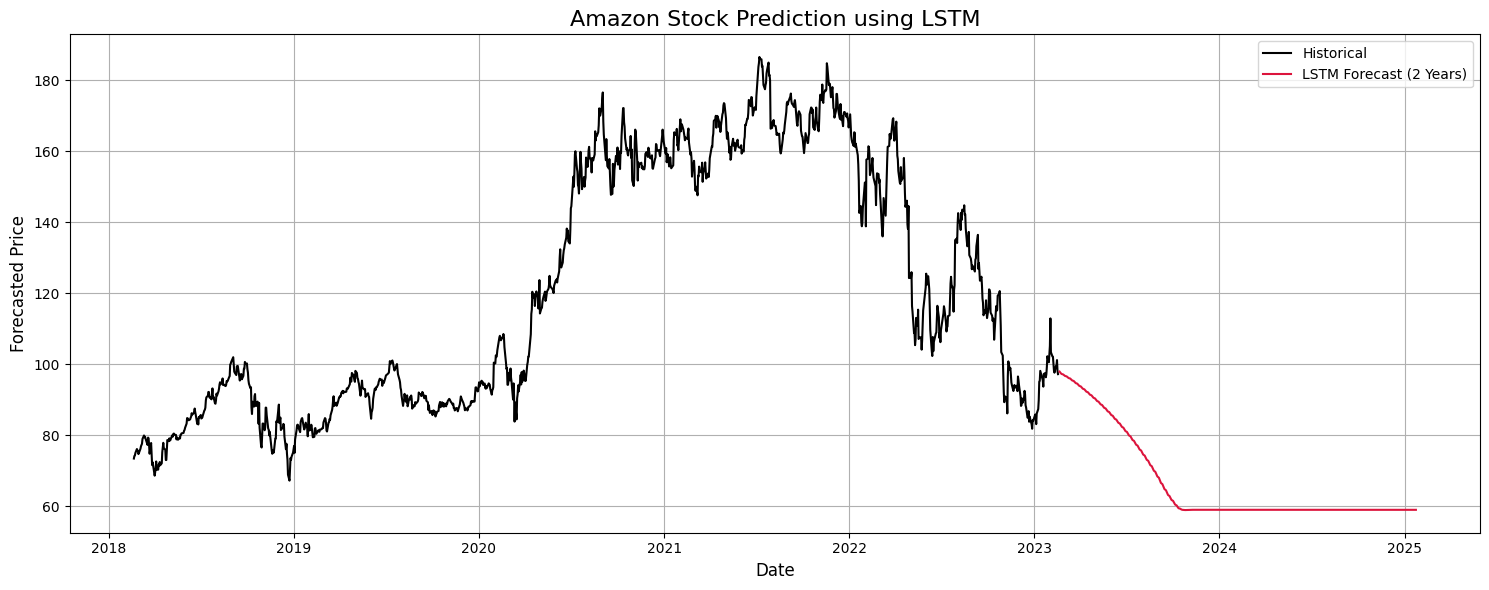

In [ ]:

# --- Normalize for LSTM ---
scaler = MinMaxScaler()
stock['Close'] = scaler.fit_transform(stock[['Close']])

# --- Sequence Preparation for LSTM ---
def make_sequences(data, window):
    X_seq, y_seq = [], []
    for i in range(len(data) - window):
        X_seq.append(data[i:i+window])
        y_seq.append(data[i+window])
    return np.array(X_seq), np.array(y_seq)

seq_len = 60
X, y = make_sequences(stock['Close'].values, seq_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- Define and Train LSTM ---
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
lstm.add(Dense(32, activation='relu'))
lstm.add(Dense(1))

lstm.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm.fit(X_train, y_train, validation_data=(X_test, y_test),
         epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)

# --- Predict with LSTM ---
lstm_pred_scaled = lstm.predict(X_test)
actual_lstm = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_lstm = scaler.inverse_transform(lstm_pred_scaled).flatten()

print("\nLSTM Evaluation:")
print("MAE :", round(mean_absolute_error(actual_lstm, predicted_lstm), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(actual_lstm, predicted_lstm)), 4))
print("MAPE:", round(mean_absolute_percentage_error(actual_lstm, predicted_lstm) * 100, 2), "%")

# --- Function: LSTM Forecasting Ahead ---
def generate_lstm_forecast(model, past_data, steps=504, window=60):
    last_seq = past_data[-window:].reshape(1, window, 1)
    forecast = []

    for _ in range(steps):
        next_val = model.predict(last_seq, verbose=0)[0][0]
        forecast.append(next_val)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_val]]], axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# --- Future Prediction using LSTM ---
lstm_future = generate_lstm_forecast(lstm, stock['Close'].values, steps=504)
lstm_dates = pd.date_range(start=stock.index[-1] + pd.Timedelta(days=1), periods=504, freq='B')

# --- Plot LSTM Forecast ---
plt.figure(figsize=(15, 6))
plt.plot(stock.index, scaler.inverse_transform(stock['Close'].values.reshape(-1, 1)), label='Historical', color='black')
plt.plot(lstm_dates, lstm_future, label='LSTM Forecast (2 Years)', color='crimson')
plt.title("Amazon Stock Prediction using LSTM", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Forecasted Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.2344 - val_loss: 0.0056
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 8.1397e-04 - val_loss: 0.0016
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.2604e-04 - val_loss: 0.0016
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 6.9628e-04 - val_loss: 0.0015
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 6.0050e-04 - val_loss: 0.0015
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 5.5514e-04 - val_loss: 0.0014
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 6.8803e-04 - val_loss: 0.0014
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 5.8811e-04 - val_loss: 0.0014
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 5.0074e-04 - val_loss: 0.0013
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 6.2969e-04 - val_loss: 0.0013
Epoch 12/50
30/30 ━━━━━━━━━

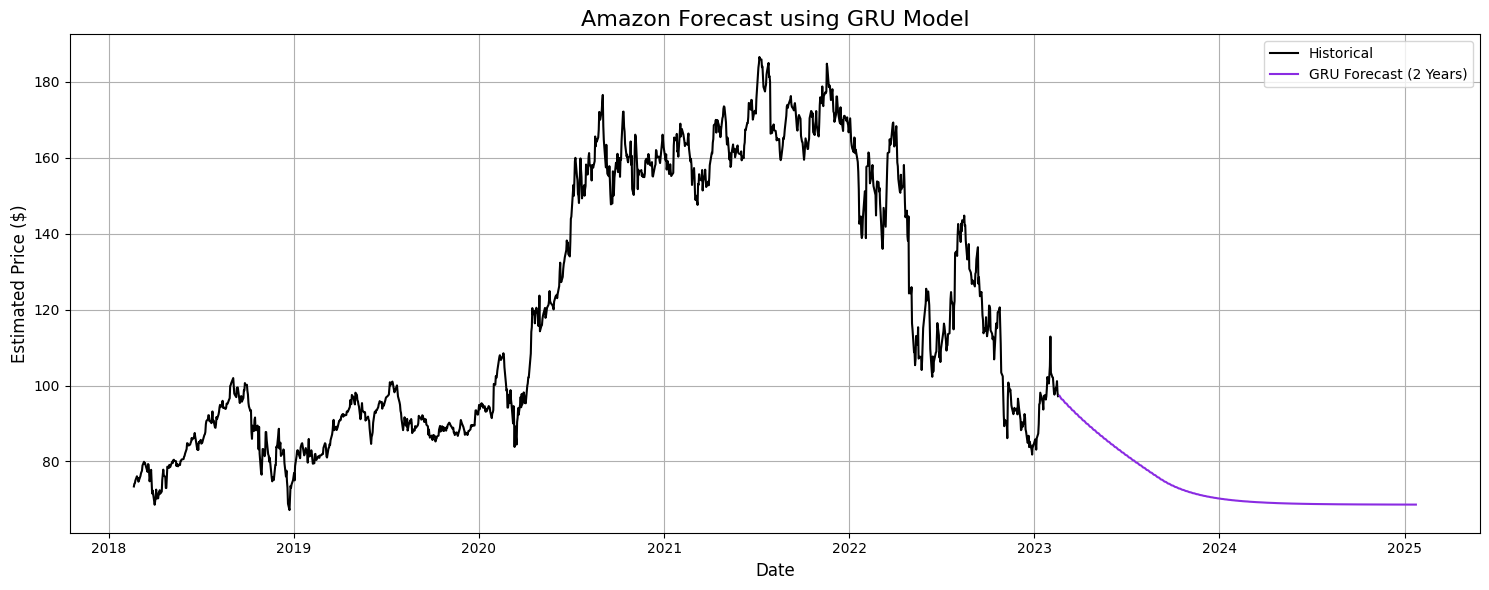

In [ ]:
# --- Prepare GRU Model for Forecasting ---

# Create GRU input sequences
def prepare_sequences(series, steps=60):
    X_seq, y_seq = [], []
    for i in range(len(series) - steps):
        X_seq.append(series[i:i+steps])
        y_seq.append(series[i+steps])
    return np.array(X_seq), np.array(y_seq)

# Set sequence window
gru_window = 60
X_gru, y_gru = prepare_sequences(stock['Close'].values, gru_window)
X_gru = X_gru.reshape((X_gru.shape[0], X_gru.shape[1], 1))

# Split into training and test sets
Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_gru, y_gru, test_size=0.2, shuffle=False)

# Build GRU model
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

gru_model = Sequential([
    GRU(64, input_shape=(Xg_train.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train GRU
gru_model.fit(
    Xg_train, yg_train,
    validation_data=(Xg_test, yg_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate GRU
gru_preds_scaled = gru_model.predict(Xg_test)
actual_gru = scaler.inverse_transform(yg_test.reshape(-1, 1)).flatten()
predicted_gru = scaler.inverse_transform(gru_preds_scaled).flatten()

# Evaluation Metrics
mae_gru = mean_absolute_error(actual_gru, predicted_gru)
rmse_gru = np.sqrt(mean_squared_error(actual_gru, predicted_gru))
mape_gru = mean_absolute_percentage_error(actual_gru, predicted_gru)

print("\nGRU Model Evaluation:")
print("MAE :", round(mae_gru, 4))
print("RMSE:", round(rmse_gru, 4))
print("MAPE:", round(mape_gru * 100, 2), "%")

# Forecast with GRU
def forecast_gru(model, recent_data, steps=504, window=60):
    seq = recent_data[-window:].reshape(1, window, 1)
    output = []
    for _ in range(steps):
        pred = model.predict(seq, verbose=0)[0][0]
        output.append(pred)
        seq = np.append(seq[:, 1:, :], [[[pred]]], axis=1)
    return scaler.inverse_transform(np.array(output).reshape(-1, 1))

# Generate future forecast
future_gru = forecast_gru(gru_model, stock['Close'].values)
future_gru_dates = pd.date_range(start=stock.index[-1] + pd.Timedelta(days=1), periods=504, freq='B')

# Plot GRU Forecast
plt.figure(figsize=(15, 6))
plt.plot(stock.index, scaler.inverse_transform(stock['Close'].values.reshape(-1, 1)), label='Historical', color='black')
plt.plot(future_gru_dates, future_gru, label='GRU Forecast (2 Years)', color='blueviolet')
plt.title("Amazon Forecast using GRU Model", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Estimated Price ($)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
